In [ ]:
#add config and make a demo run
from typing import (
    Annotated,
    Sequence,
    TypedDict,
    Union
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.prebuilt import ToolNode
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_ollama import ChatOllama
from langchain_core.messages import ToolMessage,SystemMessage
from langchain_core.runnables import RunnableConfig
import json


class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]
    generated_exps: dict
    exp_title:str
    reward:Union[int,float]
    comment:str
    Satisfied:bool
    final_formatted:dict


wrapper = DuckDuckGoSearchAPIWrapper(max_results=3)
search = DuckDuckGoSearchResults(api_wrapper=wrapper, output_format='list')

tools = [search]

model = ChatOllama(model="jacob-ebey/phi4-tools:latest",base_url="192.168.23.138:11439")
model = model.bind_tools(tools)

In [16]:
system_message = '''You are a Lab Assistant designed to assist with scientific experiments. Your task is to provide:

Experiment Materials: A list of required materials and equipment.
Experiment Steps: A detailed step-by-step guide for conducting the experiment.
Safety Procedures: Essential precautions to ensure a safe experiment.
Before generating the final response, you will:

Search the query using DuckDuckGo to gather up-to-date and relevant information.
Analyze the results to determine if the information is complete.
Enhance the response by integrating the best available knowledge before providing the final answer.which is not a summary but well explained'''

In [17]:
# class crawlerSchema(BaseModel):
#     title: str = Field(..., description="The title of the article")
#     article: str = Field(..., description="rephrase the article so that it covers every part of the topic in a concise manner in about 500 words")
#     # main_topics: str = Field(..., description="Main topics or themes discussed in the article")
#     materials: str = Field( description="extract all the materials used in the experiment")
#     steps: str = Field( description="exctract Step by step guide for conducting the experiment")
#     safety_procedures: str = Field( description="Safety precautions for the experiment")


tools_by_name = {tool.name: tool for tool in tools}
def tool_node(state: AgentState,):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        if tool_call["name"] == 'duckduckgo_results_json':
            tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            toSearch = [search['link'] for search in tool_result]
            # print(toSearch)
            crawler_result = None
            pages_result = []
            return {"messages":str(tool_result)}
            for url in toSearch:
                # print(crawlerSchema.model_json_schema()['properties'])
                
                crawler_result = test_llm_with_ollama(tester=Crawl4AiTester(), url=url, schema=crawlerSchema.model_json_schema()['properties'])
                # if crawler_result.get('success', False):  # Assuming the result has a 'success' flag
                    # print(crawler_result)
                # print(crawler_result)
                pages_result.append(crawler_result)

            crawler_result = json.dumps({"search_results": pages_result})
            
            outputs.append(
                ToolMessage(
                    content=crawler_result,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
    return {"messages": outputs}
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = SystemMessage(
        system_message
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

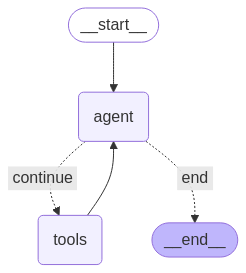

In [18]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
# query = f"what should be the required materials and experiment procedure of the following lab Experiment (To measure the input and output impedances of an operational amplifier (Op-Amp) in a given configuration.)?"
# def print_stream(stream):
#     for s in stream:
#         message = s["messages"][-1]
#         if isinstance(message, tuple):
#             print(message)
#         else:
#             message.pretty_print()


# inputs = {"messages": [("user", query)]}
# print_stream(graph.stream(inputs, stream_mode="values"))

In [20]:
from pydantic import BaseModel,Field
from typing import TypedDict,Annotated
from langchain_ollama import ChatOllama
from langgraph.graph import START, MessagesState, StateGraph,END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage
from typing import Union, Dict
import json

# formatter_llm = ChatOllama(model="jacob-ebey/phi4-tools:latest",base_url="192.168.23.138:11439")
formatter_llm = model
class score(BaseModel):
    score1: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 1")
    score2: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 2")
    score3: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 3")
    score4: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 4")
    score5: float = Field(le=1.0,ge=0.0,description="probability of getting the score of 5")

class JsonnedOutput(BaseModel):
    Accuracy: score = Field(...,description="ratings of the Accuracy in a probabilstic distribution manner")
    Completeness: score = Field(...,description="ratings of the Completeness in a probabilstic distribution manner")
    Clarity: score = Field(...,description="ratings of the Clarity in a probabilstic distribution manner")
    Safety:score = Field(...,description="ratings of the Safety in a probabilstic distribution manner")
    Comment:str = Field(...,description="give a feedback on how to improve the scores")
    Satisfied:bool = Field(...,description="are you satisfied with the experiment return True or False")

def generate_evaluation_prompt(ground_truth: Dict, test_procedure: str) -> str:
    return f"""
        You are an expert evaluator assessing the accuracy, completeness, clarity, and safety of a scientific experiment procedure.

        ### **Task**
        Compare the **Test Procedure** against the **Ground Truth** and evaluate it across four key dimensions. Provide a **probability distribution over scores [1,2,3,4,5]** for each category.

        ### **Evaluation Criteria**
        1. **Accuracy**: Are the components and steps correct?
        2. **Completeness**: Are all critical steps present?
        3. **Clarity**: Is the procedure easy to follow?
        4. **Safety**: Are safety precautions included?

        ### **Response Format (Strict JSON)**
        ```json
        {{
            "Accuracy": {{ "score1": p1, "score2": p2, "score3": p3, "score4": p4, "score5": p5 }},
            "Completeness": {{ "score1": p1, "score2": p2, "score3": p3, "score4": p4, "score5": p5 }},
            "Clarity": {{ "score1": p1, "score2": p2, "score3": p3, "score4": p4, "score5": p5 }},
            "Safety": {{ "score1": p1, "score2": p2, "score3": p3, "score4": p4, "score5": p5 }},
            "Comment: <<comment to imporve the score>>
        }}
        Each probability value must be between 0 and 1 and sum to 1.

        ### **Ground Truth**
        {json.dumps(ground_truth, indent=4)}

        ### **Test Procedure**
        {test_procedure}
        """

formatter = model.with_structured_output(JsonnedOutput,method='json_mode')
class State(TypedDict):
    input: str
    output: Union[JsonnedOutput,None]

workflow = StateGraph(state_schema=State)
def generate_graph_evaluation(state:State,config:RunnableConfig):
    # print(state["input"])
    response = model.invoke(state["input"],config)
    # print("----------------------------->",response)
    formatted_response = formatter.invoke(f"based on the {response.content} only output probabilities of each criteria and Leave everything. OUTPUT in the following json manner {{'Accuracy': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }}, 'Completeness': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }}, 'Clarity': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }},'Safety': {{ 'score1': p1, 'score2': p2, 'score3': p3, 'score4': p4, 'score5': p5 }},'Comment':<<comment to improve the score>>,'Satisfied:<<are you satisfied with the response or not return True or False }} but ensure that the json format is correct")
    # print(formatted_response)
    return {"output":{"Accuracy": formatted_response.Accuracy, "Completeness": formatted_response.Completeness,"Clarity":formatted_response.Clarity,"Safety": formatted_response.Safety,"Comment":formatted_response.Comment,"Satisfied":formatted_response.Satisfied}}

workflow.add_node("evaluator",generate_graph_evaluation)
workflow.add_edge(START,"evaluator")
workflow.add_edge("evaluator",END)
eval_graph = workflow.compile()
import os

def list_files_in_directory(directory):
    try:
        files = os.listdir(directory)
        return files
    except FileNotFoundError:
        print(f"The directory {directory} does not exist.")
    except PermissionError:
        print(f"Permission denied to access the directory {directory}.")
from typing import Dict, Optional
def evaluate_experiment(ground_truth: Dict, test_procedure: str):
    prompt = generate_evaluation_prompt(ground_truth, test_procedure)


    event = eval_graph.invoke({"input": prompt, "output": None })
        # print(event)
    # Debug: Print the raw response to see what the model is returning
    try:
        return event['output']
    except KeyError:
        return event

    

In [21]:
import logging
import json
import re
import logging
from typing import Dict, Optional
from typing import TypedDict,Literal
import tqdm
# logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s: %(message)s")
# logger = logging.getLogger(__name__)

def load_json(filepath: str) -> Dict:
    try:
        with open(filepath, "r", encoding="utf-8") as file:
            return json.load(file)
    except FileNotFoundError:
        # logger.error(f"File not found: {filepath}")
        print("file not found")
        raise
    except json.JSONDecodeError:
        # logger.error(f"Invalid JSON in file: {filepath}")
        print("file not found")
        raise
def extract_json_from_response(response_text: str) -> Optional[Dict]:
    try:
        json_match = re.search(r"\{.*\}", response_text, re.DOTALL)  # Extracts only JSON part
        if json_match:
            return json.loads(json_match.group())
        else:
            # logger.error("No valid JSON found in response.")
            print("file not found")
            return None
    except json.JSONDecodeError as e:
        # logger.error(f"JSON parsing error: {e}")
        print("file not found")
        return None



from typing import Union, Literal
import json

def load_json(file_path: str):
    with open(file_path, "r", encoding="utf-8") as file:
        return json.load(file)

def run_evaluation(
    ground_truth_path: str, 
    results_path: Union[str, dict],  
    plots: dict, 
    mode: Literal["feedback", "judge"] = "judge"
):
    # Load ground truth data
    ground_truth_data = load_json(ground_truth_path)
    ground_truth_dict = {exp["title"]: exp for exp in ground_truth_data["experiments"]}

    # Load LLM generated results based on mode
    if mode == "judge":
        llm_generated_results = load_json(results_path)["experiments"]
    elif mode == "feedback":
        llm_generated_results = results_path

    # Initialize evaluation results
    for chosen_exps in llm_generated_results:
        for title, test_procedure in chosen_exps.items():
            ground_truth = ground_truth_dict.get(title)

            if ground_truth:
                # Evaluate the experiment
                result = evaluate_experiment(ground_truth, test_procedure)
                print(result)
                comment = result.pop('Comment')
                satisfied = result.pop('Satisfied')
                # print(result)
                # Aggregate scores into plots
                for key, values in result.items():
                    # print(values)
                    score = (
                        1 * float(values.score1) +
                        2 * float(values.score2) +
                        3 * float(values.score3) +
                        4 * float(values.score4) +
                        5 * float(values.score5)
                    )
                    plots[key].append(score)
    # print(comment)
    # Handle output based on mode
    if mode == "judge":
        return plots
    else:
        # return 4.0
        total_reward = sum(plots[key][-1] for key in plots.keys())
        average_reward = total_reward / len(plots.keys())
        return average_reward,comment,satisfied


In [22]:
class formatted_output(BaseModel):
    title:str = Field(...,description="title the title of the experiment")
    objective:str = Field(...,description="copy the objective of the experiment")
    materials:list = Field(...,description="copy the materials of the experiment")
    procedure:dict = Field(...,description="copy th procedure of the experiment")

final_formatter = model.with_structured_output(formatted_output,method='json_mode')

In [23]:

def run_generator(state:AgentState):
    response = graph.invoke({"messages":  state["messages"][-1]})

    return{"generated_exps":{state["exp_title"]: response["messages"][-1].content}}

def run_evalutator(state:AgentState):
    gt = "non_code_files/experiments_2.json"
    plots = {'Accuracy':[],'Clarity':[],'Completeness':[],'Safety':[]}
    response,comment,satisfied = run_evaluation(ground_truth_path=gt,results_path=[state["generated_exps"]],mode="feedback",plots=plots)
    print(response)
    return {"reward":response,"messages":[str(state['generated_exps'])+comment],"Satisfied":satisfied}

def finally_formatter(state:AgentState):
    while True:
        try:
            resp = final_formatter.invoke(f"format the following experiment into the following category{state["generated_exps"]} of title in string, objective also in string, materials list of materials used in list,procedure copy the procedure from the given experiment and write it in a dictionary format")
            break
        except Exception as e:
            print("----------->", e)
    return {'final_formatted': {state['exp_title']:dict(resp)}}
def continue_condition(state:AgentState):
    if not state["Satisfied"]:
        return "continue"
    else:
        return "finish"
    


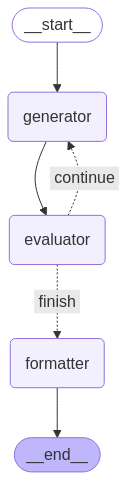

In [24]:
feedback_workflow = StateGraph(AgentState)
feedback_workflow.add_node("generator",run_generator)
feedback_workflow.add_node("evaluator",run_evalutator)
feedback_workflow.add_node("formatter",finally_formatter)
feedback_workflow.set_entry_point("generator")
feedback_workflow.add_conditional_edges("evaluator",continue_condition,{"continue":"generator","finish":'formatter'})
feedback_workflow.add_edge("generator","evaluator")
feedback_workflow.add_edge("formatter",END)
feedback_graph = feedback_workflow.compile()
feedback_graph

In [25]:
# exps_name = "To measure the input and output impedances of an operational amplifier (Op-Amp) in a given configuration."
# query = f"what should be the required materials and experiment procedure of the following lab Experiment ({exps_name})?"
# state= AgentState()
# inputs = {"messages": [("user", query)],"exp_title":exps_name}
# # for event in feedback_graph.stream(inputs):
# #     # p
# #     print(event)
# event = feedback_graph.invoke(inputs)

In [26]:
# print(event["generated_exps"])

In [27]:
experiment_name = [
    "To verify the relationship between voltage (V), current (I), and resistance (R) in an electrical circuit, as expressed by Ohm's Law: V=IRV = IRV=IR",
    "To apply Kirchhoff’s Voltage Law (KVL) and Kirchhoff’s Current Law (KCL) to analyze and validate simple electrical circuits.",
    "To study the behavior of resistors in series and parallel configurations, including the equivalent resistance calculation.",
    "To study the forward and reverse bias characteristics of a PN junction diode.",
    "To analyze voltage regulation using a Zener diode.",
    "To construct and analyze the performance of half-wave and full-wave rectifiers, both with and without filters.",
    "To analyze and implement wave-shaping circuits using diodes for clipping and clamping applications.",
    "To analyze the input and output characteristics of Bipolar Junction Transistors (BJTs) and Field-Effect Transistors (FETs).",
    "To design a common emitter amplifier and analyze its frequency response.",
    "To implement and analyze operational amplifier (Op-Amp) circuits: inverting, non-inverting, summing, and differentiator configurations.",
    "To verify the operation of basic logic gates: AND, OR, NOT, NAND, NOR, XOR, and XNOR",
    "To investigate the charging and discharging behavior of a capacitor in an RC circuit and understand the time constant.",
    "To investigate the resonance behavior of an LC circuit and measure the resonant frequency.",
    "To calibrate an oscilloscope for accurate measurements of voltage and time.",
    "To determine the turns ratio of a transformer and verify the relationship between the primary and secondary voltages.",
    "To construct and analyze a bridge rectifier circuit and compare its performance with a half-wave rectifier.",
    "To study the frequency response of a low-pass filter and determine its cutoff frequency.",
    "To measure the input and output impedances of an operational amplifier (Op-Amp) in a given configuration.",
    "To generate and analyze Lissajous figures using an oscilloscope by applying two sinusoidal signals with different frequencies.",
    "To study the magnetic field produced by a solenoid and verify the relationship between current and magnetic field strength."
]


In [28]:
experiment_dict = {"experiments":[]}
for exp in experiment_name:
    query = f"what should be the required materials and experiment procedure of the following lab Experiment ({exp})?"
    state= AgentState()
    inputs = {"messages": [("user", query)],"exp_title":exp}
    # for event in feedback_graph.stream(inputs):
    #     # p
    #     print(event)
    # event = feedback_graph.invoke(inputs)
    while True:
        try:
            event = feedback_graph.invoke(inputs)
            break
        except Exception as e:
            print("---------------------> ", e)
            continue
    
    print(exp)
    experiment_dict["experiments"].append(event["final_formatted"])
    # break

{'Accuracy': score(score1=0.05, score2=0.1, score3=0.2, score4=0.4, score5=0.25), 'Completeness': score(score1=0.0, score2=0.05, score3=0.15, score4=0.5, score5=0.3), 'Clarity': score(score1=0.0, score2=0.1, score3=0.2, score4=0.4, score5=0.3), 'Safety': score(score1=0.05, score2=0.15, score3=0.25, score4=0.35, score5=0.2), 'Comment': 'The test procedure is largely accurate and clear, with a good level of completeness. However, it could improve by explicitly mentioning the need for incremental voltage increases as specified in the ground truth. Safety precautions are mentioned but could be more detailed.', 'Satisfied': True}
3.7875
-----------> Failed to parse formatted_output from completion {"Title": "Verification of Ohm's Law (V=IR)", "Objective": "To verify the relationship between voltage (V), current (I), and resistance (R) in an electrical circuit, as expressed by Ohm's Law: V = IR", "Materials": ["DC Power Supply", "Voltmeter", "Ammeter", "Resistor(s)", "Connecting Wires", "Bre

In [29]:
event['final_formatted']

{'To study the magnetic field produced by a solenoid and verify the relationship between current and magnetic field strength.': {'title': 'To study the magnetic field produced by a solenoid and verify the relationship between current and magnetic field strength.',
  'objective': 'To conduct an experiment to study the magnetic field produced by a solenoid and verify the relationship between current and magnetic field strength, you will need specific materials and follow a detailed procedure.',
  'materials': ['Solenoid: A coil of wire with multiple turns.',
   'Power Supply: To provide adjustable current to the solenoid.',
   'Ammeter: To measure the current flowing through the solenoid.',
   'Magnetic Field Sensor or Gaussmeter: To measure the magnetic field strength inside and around the solenoid.',
   'Connecting Wires: For making electrical connections.',
   'Multimeter: To verify voltage and resistance if needed.',
   'Alligator Clips: For easy connection of wires to the solenoid.'

In [30]:
import json
with open("phi4_exps_w_feedback/qwen2.5_feedback_output_3.json","w") as F:
    json.dump(experiment_dict,F,indent=4)

In [31]:
with open("exps.json","w") as F:
    F.write(json.dumps(experiment_dict))

In [ ]:
from IPython.display import Markdown, display

display(Markdown(experiment_dict['experiments'][0]['To design a common emitter amplifier and analyze its frequency response.']))

KeyError: 'To design a common emitter amplifier and analyze its frequency response.'

: 

In [ ]:
import json

# Load the JSON file
file_path = "phi4_exps_w_feedback/qwen2.5_feedback_output_1.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract all components and count them
total_components = 0
components_with_values = 0

# Keywords for identifying components with values
value_indicators = ["Ω", "ohm", "kΩ", "MΩ", "µF", "uF", "F", "H", "mH", "μH", "V", "A", "mA"]

# Iterate through experiments to find component mentions
for experiment in data.get("experiments", []):
    for key, content in experiment.items():
        lines = content.split("\n")
        for line in lines:
            if any(keyword in line.lower() for keyword in ["resistor", "capacitor", "diode", "transistor", "op-amp", "voltmeter", "ammeter", "power supply", "inductor", "multimeter", "oscilloscope", "wire", "breadboard"]):
                total_components += 1
                if any(value in line for value in value_indicators):
                    components_with_values += 1

total_components, components_with_values


(350, 155)